In [11]:
require(dplyr)
require(ggpubr)
require(data.table)
library(tidyverse)
options(warn = -1)

**Parameters**

In [12]:
# Inputs
inputpath_perez2022 <- "data/Compare_SLE_subgroups/STAT1_SP1_perez2022_level1.csv"
inputpath_scgt00 <- "data/Compare_SLE_subgroups/STAT1_SP1_scgt00_level1.csv"

inputpath_perez2022_level2 <- "data/Compare_SLE_subgroups/STAT1_SP1_perez2022_Level2.csv"
inputpath_scgt00_level2 <- "data/Compare_SLE_subgroups/STAT1_SP1_scgt00_Level2.csv"

# Outputs
outputpath <- "results/"

# Palette
color_palette_path <- "data/colors_palette.R"
source(color_palette_path)

# Load data

In [13]:
perez2022_level1 <- read.csv(inputpath_perez2022, header = TRUE)
scgt00_level1 <- read.csv(inputpath_scgt00, header = TRUE)

perez2022_level2 <- read.csv(inputpath_perez2022_level2, header = TRUE)
scgt00_level2 <- read.csv(inputpath_scgt00_level2, header = TRUE)

# Extended Data Figure 3

In [14]:
tf_order <- c("STAT1", "SP1")
l1_cell_type_order <- names(cell_colors)
l2_cell_type_order <- names(cell_level2_colors)

In [15]:
toplot_perez <-
    perez2022_level2 %>%
    filter(!Level1 %in% c("Cycling_cells", "Progenitors", "Platelets"))

toplot_scgt00 <-
    scgt00_level2 %>%
    filter(!Level1 %in% c("Cycling_cells", "Progenitors", "Platelets"))
toplot_level2 <- rbind(toplot_perez, toplot_scgt00)  %>%
  pivot_longer(cols = c(STAT1, SP1), names_to = "TF", values_to = "activity") %>%
  mutate(
    Level1 = factor(Level1, levels = l1_cell_type_order),
    Level2 = factor(Level2, levels = l2_cell_type_order),
    TF = factor(TF, levels = tf_order)
  )

**p-val**

In [16]:
library(dplyr)
library(broom)
library(tidyr)
library(purrr)

# Define a function to perform one-vs-all Wilcoxon tests for each Level2 within Level1
compare_one_vs_all <- function(data) {
  # List to store results
  results <- list()
  
  # Loop over each Level1 category
  unique_level1 <- unique(data$Level1)
  for (level1 in unique_level1) {
    # Filter data for the current Level1 category and remove rows where activity is NA
    level1_data <- data %>%
      filter(Level1 == level1, !is.na(activity))
    
    # Get unique combinations of Level2 and TF
    combinations <- expand.grid(Level2 = unique(level1_data$Level2), TF = unique(level1_data$TF))
    
    # Perform one-vs-all comparisons for each combination
    for (i in 1:nrow(combinations)) {
      level2 <- combinations$Level2[i]
      tf <- combinations$TF[i]
      
      # Filter data for the current Level2 and TF
      one_data <- level1_data %>% filter(Level2 == level2, TF == tf)
      all_data <- level1_data %>% filter(Level2 != level2, TF == tf)

      mean_one <- mean(one_data$activity)
      mean_all <- mean(all_data$activity)
      
      # Ensure there are at least two observations in each group
      if (nrow(one_data) >= 3 && nrow(all_data) >= 3) {
        # Perform Wilcoxon test (one-sided: greater)
        test_result <- wilcox.test(one_data$activity, all_data$activity, alternative = "two.sided")
        
        # Clean up and store the result
        tidy_result <- tidy(test_result)
        tidy_result$Level1 <- level1
        tidy_result$Level2 <- level2
        tidy_result$TF <- tf
        tidy_result$mean_one <- mean_one
        tidy_result$mean_all <- mean_all
        results[[paste(level1, level2, tf)]] <- tidy_result
      }
    }
  }
  
  # Combine all results into a single data frame
  final_results <- bind_rows(results, .id = "comparison")
  return(final_results)
}

# Example usage with your data frame
final_comparison_results <- compare_one_vs_all(toplot_level2)

In [17]:
library(dplyr)

# Assuming final_comparison_results is already created
final_comparison_results_adjusted <- final_comparison_results %>%
  # Adjust p-values globally first
  mutate(
    pval_adj = p.adjust(p.value, method = "BH")
  ) %>%
  # Group by TFs to adjust p-values within each TF group
  #group_by(TF) %>%
  #mutate(
  #  pval_adj_indep = p.adjust(p.value, method = "BH")
  #) %>%
  #ungroup() %>%
  # Filter based on the unadjusted p-value
  #filter(pval_adj < 0.05) %>%
  # Arrange by p-value to see the most significant results first
  arrange(Level1, TF, pval_adj)

output_path <- "results/supplementary_tables/SLE_Level2_pval.csv"
write.csv(final_comparison_results_adjusted, output_path, row.names = FALSE)

# Print the adjusted and filtered results
final_comparison_results_adjusted

comparison,statistic,p.value,method,alternative,Level1,Level2,TF,mean_one,mean_all,pval_adj
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
ILC NK_lowRibocontent SP1,8964.0,1.283159e-09,Wilcoxon rank sum test with continuity correction,two.sided,ILC,NK_lowRibocontent,SP1,-0.342425391,0.20283399,1.154843e-08
ILC NK_adaptive SP1,27821.0,3.469194e-05,Wilcoxon rank sum test with continuity correction,two.sided,ILC,NK_adaptive,SP1,0.409337594,0.06087694,1.135373e-04
ILC NK_CD56dimCD16 SP1,31022.0,1.289171e-03,Wilcoxon rank sum test with continuity correction,two.sided,ILC,NK_CD56dimCD16,SP1,0.312912263,0.06838008,2.900636e-03
ILC NK_IFN1response SP1,10179.0,8.454847e-02,Wilcoxon rank sum test with continuity correction,two.sided,ILC,NK_IFN1response,SP1,0.003605688,0.14268336,1.449402e-01
ILC NK_CD56high SP1,22554.0,1.123243e-01,Wilcoxon rank sum test with continuity correction,two.sided,ILC,NK_CD56high,SP1,-0.009442693,0.17171453,1.838033e-01
ILC NK_CD16high SP1,12245.0,4.722113e-01,Wilcoxon rank sum test with continuity correction,two.sided,ILC,NK_CD16high,SP1,0.204182768,0.12204616,6.299905e-01
Mono Mono_IFNresponse STAT1,51741.0,3.066814e-21,Wilcoxon rank sum test with continuity correction,two.sided,Mono,Mono_IFNresponse,STAT1,2.450774366,1.14031489,1.104053e-19
Mono Mono_regulatory STAT1,12725.0,3.095138e-09,Wilcoxon rank sum test with continuity correction,two.sided,Mono,Mono_regulatory,STAT1,0.529648683,1.56074646,2.228499e-08
Mono Mono_nonClassical STAT1,26507.0,2.326705e-04,Wilcoxon rank sum test with continuity correction,two.sided,Mono,Mono_nonClassical,STAT1,0.941861006,1.56626926,5.982955e-04


**Boxplots**

In [18]:
plot_l2 <- ggboxplot(toplot_level2, x = "Level2", y = "activity", fill = "Level2") +
    facet_grid(rows = vars(TF), cols = vars(Level1), scales = "free_x"
              ) +
    scale_fill_manual(values = cell_level2_colors) +
    theme_bw() +
    ggtitle(label = "") +
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=0.5)
    )

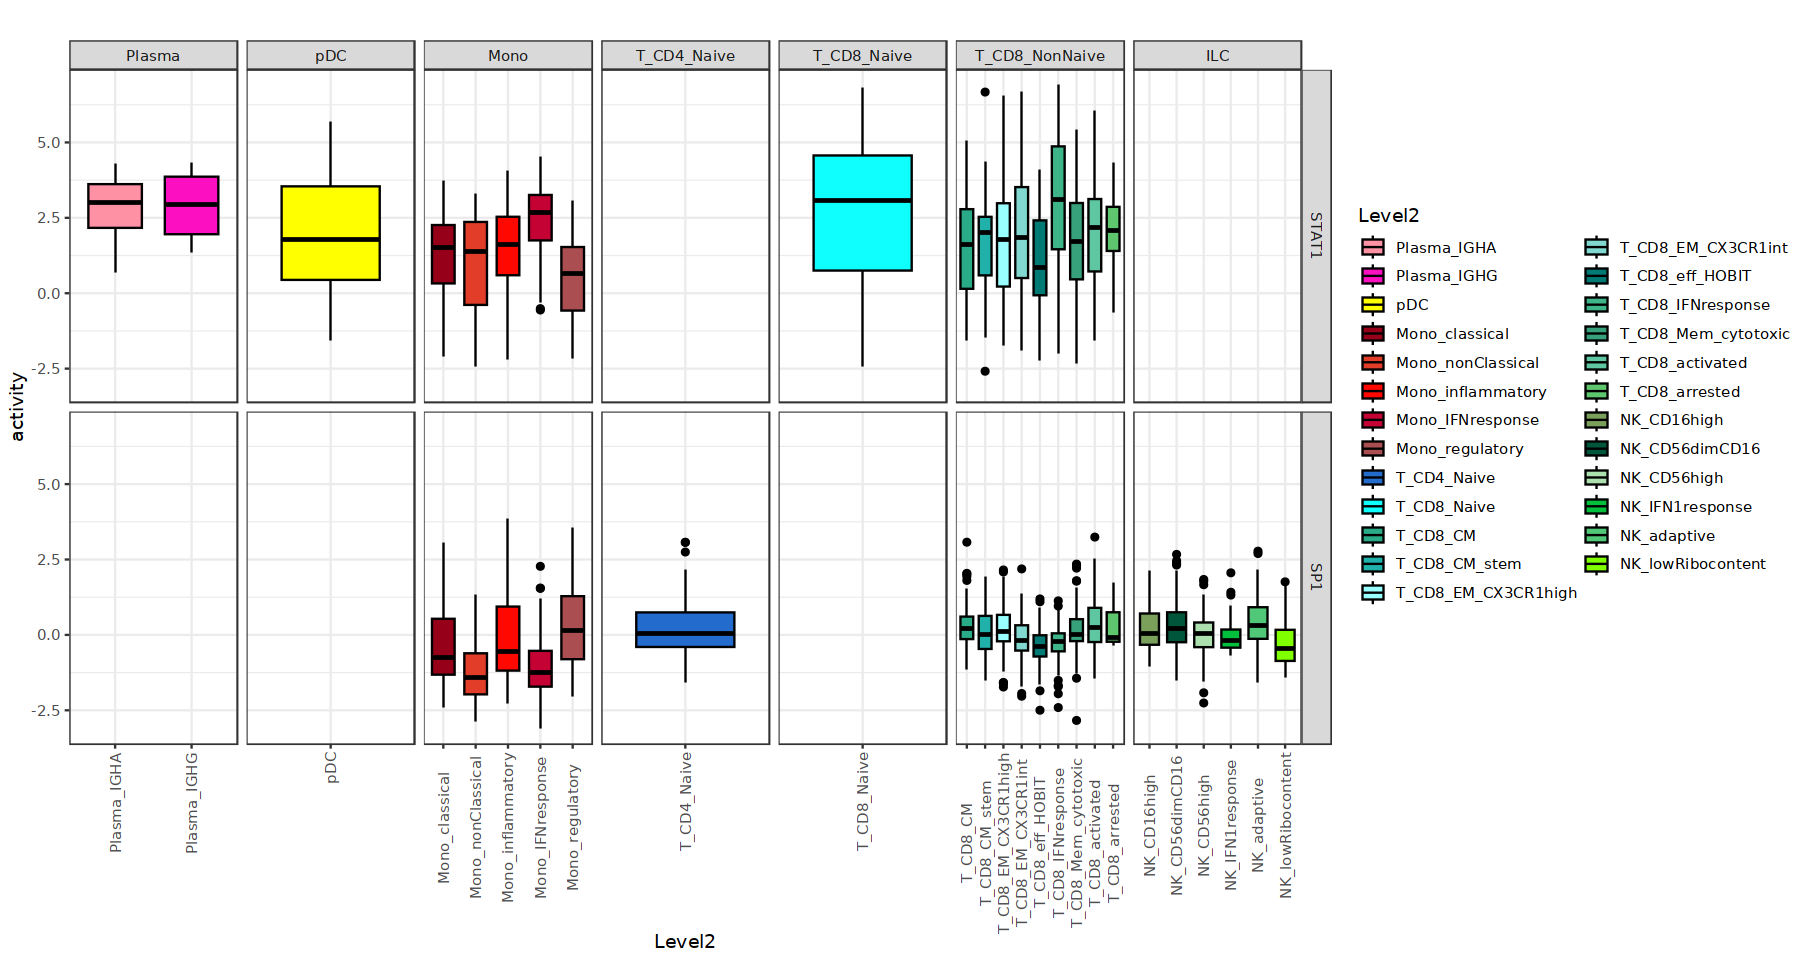

In [23]:
plot_l2

In [36]:
ggsave(
    plot_l2,
    filename = "sle_TFactivity_level2_test.pdf",
    device = "pdf",
    width = 20,
    height = 8,
    path = outputpath)